1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


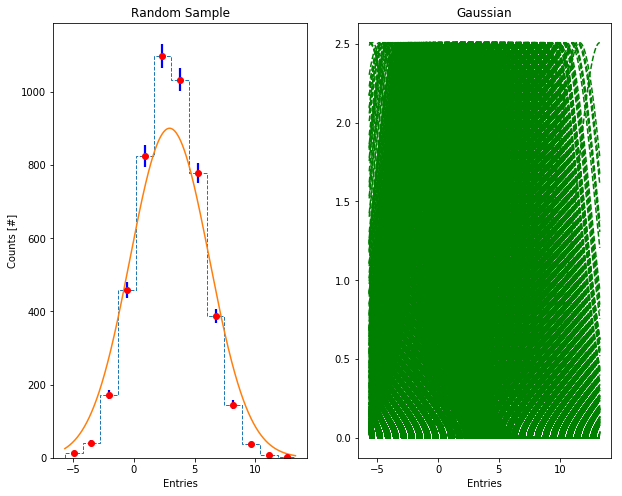

In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 
import scipy as sc

N=5000
sigma=2.5
mu=3
np.random.seed(415)
array0= np.random.normal( mu, sigma, N)
# Choice of the number of bins following the formula of Sturges' formula.
_,(a0,a1) = plt.subplots(nrows=1, ncols=2, figsize=(10,8))
bins=int(round(math.log(N,2)+1,0))
counts,edge,ignored= a0.hist(array0,histtype='step',bins=bins,linestyle='dashed')
centers = (edge[1:] + edge[:-1])/2
a0.set_ylabel('Counts [#]')
a0.set_xlabel('Entries')
a0.set_title("Random Sample")
a0.errorbar(centers, counts, ecolor="blue",elinewidth=2.2,fmt="ro",yerr=np.sqrt(counts))
KDEstd = 1.06*array0.std()*(array0.size)**(-1/5)+2
gauss_sum = np.empty((N,N))
a1.set_xlabel('Entries')
a1.set_title("Gaussian")
ran=np.linspace(array0.min(),array0.max(),N)
for i in range(len(array0)):
    gaussianpoint = norm.pdf(ran,loc=array0[i],scale=KDEstd)*2*math.pi*KDEstd
    gauss_sum[i,:] = gaussianpoint
    a1.plot(ran, gaussianpoint, 'g--')
G=np.sum(gauss_sum,axis=0)
gauss = G*sum(counts*(edge[1:] - edge[:-1])) / sc.integrate.trapz(y=G, x=ran)
a0.plot(ran,gauss)


2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

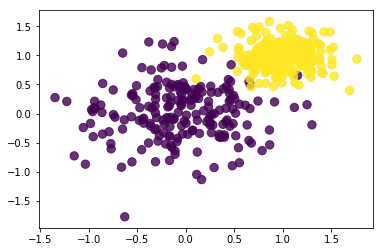

In [7]:
#! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
#couldn't allocate memory so I downloaded it and loaded it
from IPython.display import Image
Image('QSMCdO-Q.png')


Mean : 1
Std : 0.1
Mean : 2
Std : 0.2
Mean : 3
Std : 0.3
Mean : 4
Std : 0.4


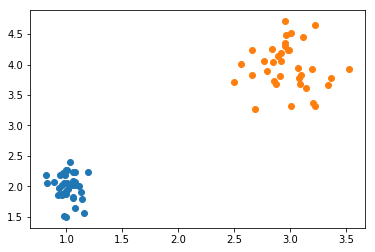

In [9]:
import numpy as np
def N_norm_dataset(n):
    np.random.seed(5764)
    size=9
    mu=np.empty(n)
    sigma=np.empty(n)
    arrays=np.empty([n,2*size,2])
    for i in range(n):
        try:
            mu[i]=float(raw_input('Mean : '))
            sigma[i]=float(raw_input('Std : '))
        except ValueError:
            print "Both must be numbers"
        subarray=sigma[i] * np.random.randn(1,2*size,2) + mu[i]
        arrays[i]=subarray
    return arrays

array0,array1,array2,array3=N_norm_dataset(4)
plt.scatter(array0,array1)
plt.scatter(array2,array3)


3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should you the `np.load()` function to load the file as a numpy array and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 

In [26]:
import pandas as pd
from scipy import stats

#import data into a data frame
df = pd.DataFrame(np.load('residuals_261.npy', allow_pickle=True).item())

In [27]:
mask = abs(df['residuals'])<2.0

In [37]:
#df[mask]
df_new = df[mask]
x = df_new['residuals']
y = df_new['distances']
result = stats.linregress(x,y)

In [38]:
print(result)

LinregressResult(slope=0.577913366635926, intercept=10.025258299436526, rvalue=0.043403510522559086, pvalue=8.717037183576464e-06, stderr=0.1298980963225655)


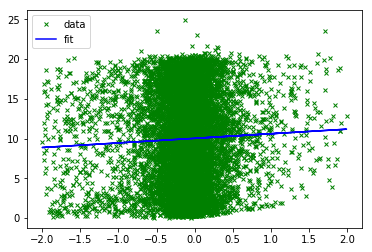

In [39]:
slope=result[0]
intercept = result[1]
rvalue = result[2]
pvalue = result[3]
err = result[4]
plt.plot(x, y, 'gx', label='data',markersize=4)
#linear fit = m*x+b
plt.plot(x, intercept + slope*x, 'b', label='fit')
plt.legend()
plt.show()


* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [51]:
import seaborn as sns

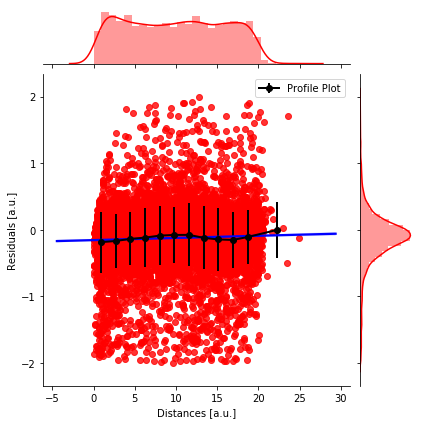

In [54]:
sns_plot=sns.jointplot(x="distances",y="residuals",data=df_new,kind="reg",color="red",joint_kws={'line_kws':{'color':'blue'}})

bins=int(round(math.log(df_new.shape[0],2)+1,0))
steps=(df_new["distances"].max()-(df_new["distances"].min()))/bins
temp=0
edges=np.empty(bins+1)
for i in range(bins+1):
    edges[i]=temp
    temp +=steps 
edges =np.delete(edges,[12,13],0)
bins=bins-2
centralbins=(edges[1:]+edges[:-1])/2
y=np.array([df_new.loc[(df_new['distances'] >=edges[i]) & (df_new['distances'] <edges[i+1])]['residuals'].mean() for i in range(bins)])
erry=np.array([df_new.loc[(df_new['distances'] >=edges[i]) & (df_new['distances'] <edges[i+1])]['residuals'].std() for i in range(bins)])
plt.errorbar(centralbins,y,yerr=erry, label='Profile Plot',linewidth=2,color='k',marker='o')
plt.xlabel('Distances [a.u.]')
plt.ylabel('Residuals [a.u.]')
sns_plot.ax_joint.legend()
